In [1]:
%pip install graphiti-core langchain-openai langgraph ipywidgets


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import asyncio
import json
import logging
import os
import sys
import uuid
from contextlib import suppress
from datetime import datetime
from pathlib import Path
from typing import Annotated

import ipywidgets as widgets
from dotenv import load_dotenv, find_dotenv
from IPython.display import Image, display
from typing_extensions import TypedDict

from graphiti_core import Graphiti
from graphiti_core.edges import EntityEdge
from graphiti_core.nodes import EpisodeType
from graphiti_core.utils.bulk_utils import RawEpisode
from graphiti_core.utils.maintenance.graph_data_operations import clear_data

In [3]:

dotenv_path = '/Users/arthurj/copilot/.env'
load_dotenv(dotenv_path)

True

In [4]:

neo4j_uri = os.getenv('NEO4J_URI', 'bolt://localhost:7687')
neo4j_user = os.getenv('NEO4J_USER', 'neo4j')
neo4j_password = os.getenv('NEO4J_PASSWORD', 'Y8cL8y5p')
neo4j_database = os.getenv('NEO4J_DATABASE', 'test')

client = Graphiti(
    neo4j_uri,
    neo4j_user,
    neo4j_password,
   #neo4j_database
)

In [5]:
await clear_data(client.driver)
await client.build_indices_and_constraints()

In [6]:
async def ingest_sales_data(client: Graphiti):
    json_file_path = '/Users/arthurj/Downloads/manybirds_products.json'

    with open(json_file_path) as file:
        products = json.load(file)['products']
    episodes: list[RawEpisode] = [
        RawEpisode(
            name=product.get('title', f'Product {i}'),
            content=str({k: v for k, v in product.items() if k != 'images'}),
            source_description='ManyBirds products',
            source=EpisodeType.json,
            reference_time=datetime.now(),
        )
        for i, product in enumerate(products)
    ]
    await client.add_episode_bulk(episodes)
    
await ingest_sales_data(client)

In [7]:
user_name = 'jess'

await client.add_episode(
    name='User Creation',
    episode_body=(f'{user_name} is interested in buying a pair of shoes'),
    source=EpisodeType.text,
    reference_time=datetime.now(),
    source_description='SalesBot',
)

# let's get Jess's node uuid
nl = await client.get_nodes_by_query(user_name)

user_node_uuid = nl[0].uuid

# and the ManyBirds node uuid
nl = await client.get_nodes_by_query('ManyBirds')
manybirds_node_uuid = nl[0].uuid

In [8]:
def edges_to_facts_string(entities: list[EntityEdge]):
    return '-' + '\n- '.join([edge.fact for edge in entities])

In [9]:
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, add_messages
from langgraph.prebuilt import ToolNode

In [10]:
@tool
async def get_shoe_data(query: str) -> str:
    """Search the graphiti graph for information about shoes"""
    edge_results = await client.search(
        query,
        center_node_uuid=manybirds_node_uuid,
        num_results=10,
    )
    return edges_to_facts_string(edge_results)


tools = [get_shoe_data]
tool_node = ToolNode(tools)

In [11]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0).bind_tools(tools)

In [12]:
await tool_node.ainvoke({'messages': [await llm.ainvoke('wool shoes')]})

{'messages': [ToolMessage(content="-Manybirds produces the Men's Couriers - Natural Black/Basin Blue (Blizzard Sole) shoes.\n- Manybirds produces the TinyBirds Wool Runners - Little Kids - Natural Black (Blizzard Sole).\n- Manybirds produces the Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole).\n- The TinyBirds Wool Runners - Little Kids - Natural Black (Blizzard Sole) belong to the Shoes category.\n- The Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) are made of wool.\n- The Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) belong to the Shoes category.\n- The Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) are available in various sizes.\n- The design style of the Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) is runner.\n- The Men's SuperLight Wool Runners - Dark Grey (Medium Grey Sole) target the mens gender.\n- The TinyBirds Wool Runners - Little Kids - Natural Black (Blizzard Sole) have a size variant of 8T.", name='

In [13]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_name: str
    user_node_uuid: str


async def chatbot(state: State):
    facts_string = None
    if len(state['messages']) > 0:
        last_message = state['messages'][-1]
        graphiti_query = f'{"SalesBot" if isinstance(last_message, AIMessage) else state["user_name"]}: {last_message.content}'
        # search graphiti using Jess's node uuid as the center node
        # graph edges (facts) further from the Jess node will be ranked lower
        edge_results = await client.search(
            graphiti_query, center_node_uuid=state['user_node_uuid'], num_results=5
        )
        facts_string = edges_to_facts_string(edge_results)

    system_message = SystemMessage(
        content=f"""You are a skillfull shoe salesperson working for ManyBirds. Review information about the user and their prior conversation below and respond accordingly.
        Keep responses short and concise. And remember, always be selling (and helpful!)

        Things you'll need to know about the user in order to close a sale:
        - the user's shoe size
        - any other shoe needs? maybe for wide feet?
        - the user's preferred colors and styles
        - their budget

        Ensure that you ask the user for the above if you don't already know.

        Facts about the user and their conversation:
        {facts_string or 'No facts about the user and their conversation'}"""
    )

    messages = [system_message] + state['messages']

    response = await llm.ainvoke(messages)

    # add the response to the graphiti graph.
    # this will allow us to use the graphiti search later in the conversation
    # we're doing async here to avoid blocking the graph execution
    asyncio.create_task(
        client.add_episode(
            name='Chatbot Response',
            episode_body=f"{state['user_name']}: {state['messages'][-1]}\nSalesBot: {response.content}",
            source=EpisodeType.message,
            reference_time=datetime.now(),
            source_description='Chatbot',
        )
    )

    return {'messages': [response]}

In [14]:
graph_builder = StateGraph(State)

memory = MemorySaver()


# Define the function that determines whether to continue or not
async def should_continue(state, config):
    messages = state['messages']
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return 'end'
    # Otherwise if there is, we continue
    else:
        return 'continue'


graph_builder.add_node('agent', chatbot)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges('agent', should_continue, {'continue': 'tools', 'end': END})
graph_builder.add_edge('tools', 'agent')


graph = graph_builder.compile(checkpointer=memory)

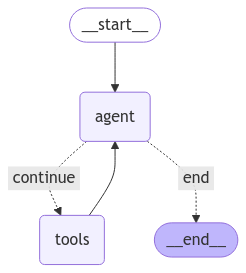

In [15]:
from IPython.display import display, Image
from contextlib import suppress


with suppress(Exception):
    image_data = graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data)) 


In [16]:
await graph.ainvoke(
    {
        'messages': [
            {
                'role': 'user',
                'content': 'What sizes do the TinyBirds Wool Runners in Natural Black come in?',
            }
        ],
        'user_name': user_name,
        'user_node_uuid': user_node_uuid,
    },
    config={'configurable': {'thread_id': uuid.uuid4().hex}},
)

{'messages': [HumanMessage(content='What sizes do the TinyBirds Wool Runners in Natural Black come in?', additional_kwargs={}, response_metadata={}, id='ea21fc02-aeeb-4c20-966d-65a4bc97f6ab'),
  AIMessage(content='The TinyBirds Wool Runners - Little Kids in Natural Black (Blizzard Sole) are available in size variants of 10T and 6T. Would you like to know more about these sizes or perhaps check out other options?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 311, 'total_tokens': 360, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-c05ddad9-7ba7-4f9b-b4e3-9d7ddb7dd268-0', usage_metadata={'input_tokens': 311, 'output_tokens': 49, 'total